In [1]:
import os
import pandas as pd
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler
from scipy.fft import fft
import numpy as np
import librosa
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

In [2]:
def calculate_spectral_centroid(signal, sr):
    return np.mean(librosa.feature.spectral_centroid(y=signal, sr=sr))

def calculate_spectral_bandwidth(signal, sr):
    return np.mean(librosa.feature.spectral_bandwidth(y=signal, sr=sr))

def calculate_spectral_rolloff(signal, sr):
    return np.mean(librosa.feature.spectral_rolloff(y=signal, sr=sr))

def calculate_zero_crossing_rate(signal):
    return np.mean(librosa.feature.zero_crossing_rate(signal))

def calculate_rms(signal):
    return librosa.feature.rms(y=signal)[0][0]

def calculate_mfccs(signal, sr, n_mfcc=13):
    mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=n_mfcc)
    return np.mean(mfccs, axis=1)

def calculate_chroma_stft(signal, sr):
    chroma_stft = librosa.feature.chroma_stft(y=signal, sr=sr)
    return np.mean(chroma_stft, axis=1)

def calculate_tonnetz(signal, sr):
    tonnetz = librosa.feature.tonnetz(y=signal, sr=sr)
    return np.mean(tonnetz, axis=1)

In [3]:
# 데이터 로드 및 전처리 함수
def load_and_preprocess_data(normal_folder, abnormal_folder, folders, split_size=256, overlap=0.25):
    data = []
    labels = []

    for folder in folders:
        normal_folder_path = os.path.join(normal_folder, f"{folder}")
        abnormal_folder_path = os.path.join(abnormal_folder, f"{folder}")

        for is_abnormal, folder_path in enumerate([normal_folder_path, abnormal_folder_path]):
            for file_name in os.listdir(os.path.join(folder_path, 'time_vib')):
                file_path = os.path.join(folder_path, 'time_vib', file_name)
                df = pd.read_csv(file_path, header=None, delimiter=',')

                step_size = int(split_size * (1 - overlap))
                for i in range(0, len(df.columns), step_size):
                    segment = df.iloc[:, i:i+split_size].values.flatten()

                    # 주파수 영역의 특성 추가 (FFT)
                    spectrum = fft(segment)
                    frequency_features = np.abs(spectrum)[:len(spectrum)//2]

                    spectral_centroid_val = calculate_spectral_centroid(segment, sr=15000)
                    spectral_bandwidth_val = calculate_spectral_bandwidth(segment, sr=15000)
                    spectral_rolloff_val = calculate_spectral_rolloff(segment, sr=15000)
                    zero_crossing_rate_val = calculate_zero_crossing_rate(segment)
                    rms_val = calculate_rms(segment)
                    mfccs_val = calculate_mfccs(segment, sr=15000)
                    chroma_stft_val = calculate_chroma_stft(segment, sr=15000)
                    tonnetz_val = calculate_tonnetz(segment, sr=15000)

                    features = list(segment) + [frequency_features.mean(), frequency_features.max(), frequency_features.min(),
                                                frequency_features.std(), frequency_features.sum(),
                                                spectral_centroid_val, spectral_bandwidth_val, spectral_rolloff_val,
                                                zero_crossing_rate_val, rms_val] + \
                               list(mfccs_val) + list(chroma_stft_val) + list(tonnetz_val)
                    data.append(features)
                    labels.append(is_abnormal)

    return data, labels


In [4]:
# 데이터 로드 및 전처리
normal_folder_path = "/content/drive/MyDrive/IC-PBL/normal"
abnormal_folder_path = "/content/drive/MyDrive/IC-PBL/abnormal"
train_folders = range(1, 31)
test_folders = range(31, 41)

train_data, train_labels = load_and_preprocess_data(normal_folder_path, abnormal_folder_path, train_folders)
test_data, test_labels = load_and_preprocess_data(normal_folder_path, abnormal_folder_path, test_folders)

# 데이터 정규화
scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.transform(test_data)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=512 is too large for input signal of length=128
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=512 is too large for input signal of length=64
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=512 is too large for input signal of length=32
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=512 is too large for input signal of length=256
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=512 is too large for input signal of length=128
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=512 is too large for input signal of length=64
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/lib

In [5]:
# 하이퍼파라미터 그리드 설정
param_grid = {'C': [0.05, 0.1], 'gamma': [ 0.001, 0.01,], 'kernel': ['linear']}

##최적 하이퍼파라미터: {'C': 0.1, 'gamma': 0.001, 'kernel': 'linear'}

# 그리드 서치를 통한 최적 하이퍼파라미터 탐색
grid_search = GridSearchCV(SVC(class_weight={0: 1, 1: 2}), param_grid, cv=3, scoring='accuracy')
grid_search.fit(train_data_scaled, train_labels)

# 최적 하이퍼파라미터 출력
best_params = grid_search.best_params_
print("최적 하이퍼파라미터:", best_params)

# 최적 하이퍼파라미터로 SVM 모델 학습
svm_model_best = SVC(class_weight={0: 1, 1: 2}, **best_params)
svm_model_best.fit(train_data_scaled, train_labels)


최적 하이퍼파라미터: {'C': 0.05, 'gamma': 0.001, 'kernel': 'linear'}


SVC(C=0.05, class_weight={0: 1, 1: 2}, gamma=0.001, kernel='linear')

In [6]:
# 테스트 데이터에 모델 적용
svm_best_predictions = svm_model_best.predict(test_data_scaled)

# 정확도 계산
svm_best_accuracy = accuracy_score(test_labels, svm_best_predictions)

# 분류 보고서 출력
svm_best_classification_report = classification_report(test_labels, svm_best_predictions)

# ROC AUC 계산
svm_probabilities = svm_model_best.decision_function(test_data_scaled)
roc_auc = roc_auc_score(test_labels, svm_probabilities)


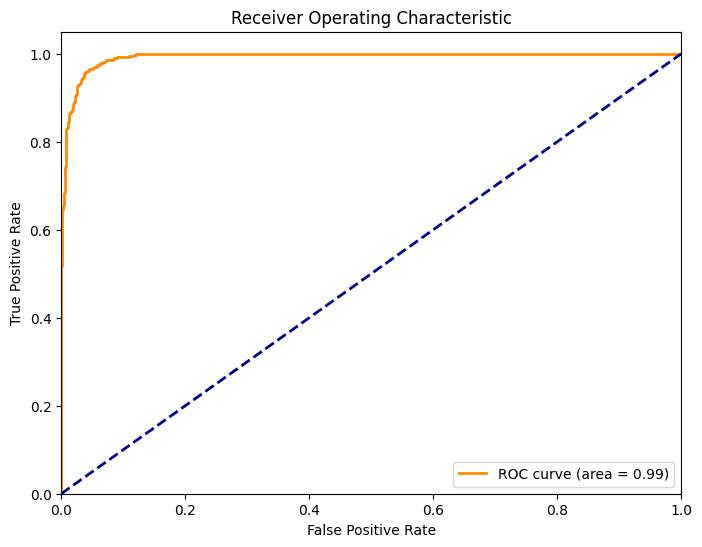

In [7]:
# ROC 곡선 그리기
fpr, tpr, _ = roc_curve(test_labels, svm_probabilities)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


In [8]:
# 결과 출력
print(f"SVM Best Accuracy: {svm_best_accuracy}")
print("SVM Best Classification Report:\n", svm_best_classification_report)
print("ROC AUC Score:", roc_auc)


SVM Best Accuracy: 0.949556282111163
SVM Best Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.91      0.95      1084
           1       0.91      0.99      0.95      1057

    accuracy                           0.95      2141
   macro avg       0.95      0.95      0.95      2141
weighted avg       0.95      0.95      0.95      2141

ROC AUC Score: 0.9926618187657752
